/var/folders/mv/kmw6ll6n07s92fsv8f90xzn00000gn/T/ipykernel_29888/3076004863.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread('Tavola5_episodio1_cap13.JPG')


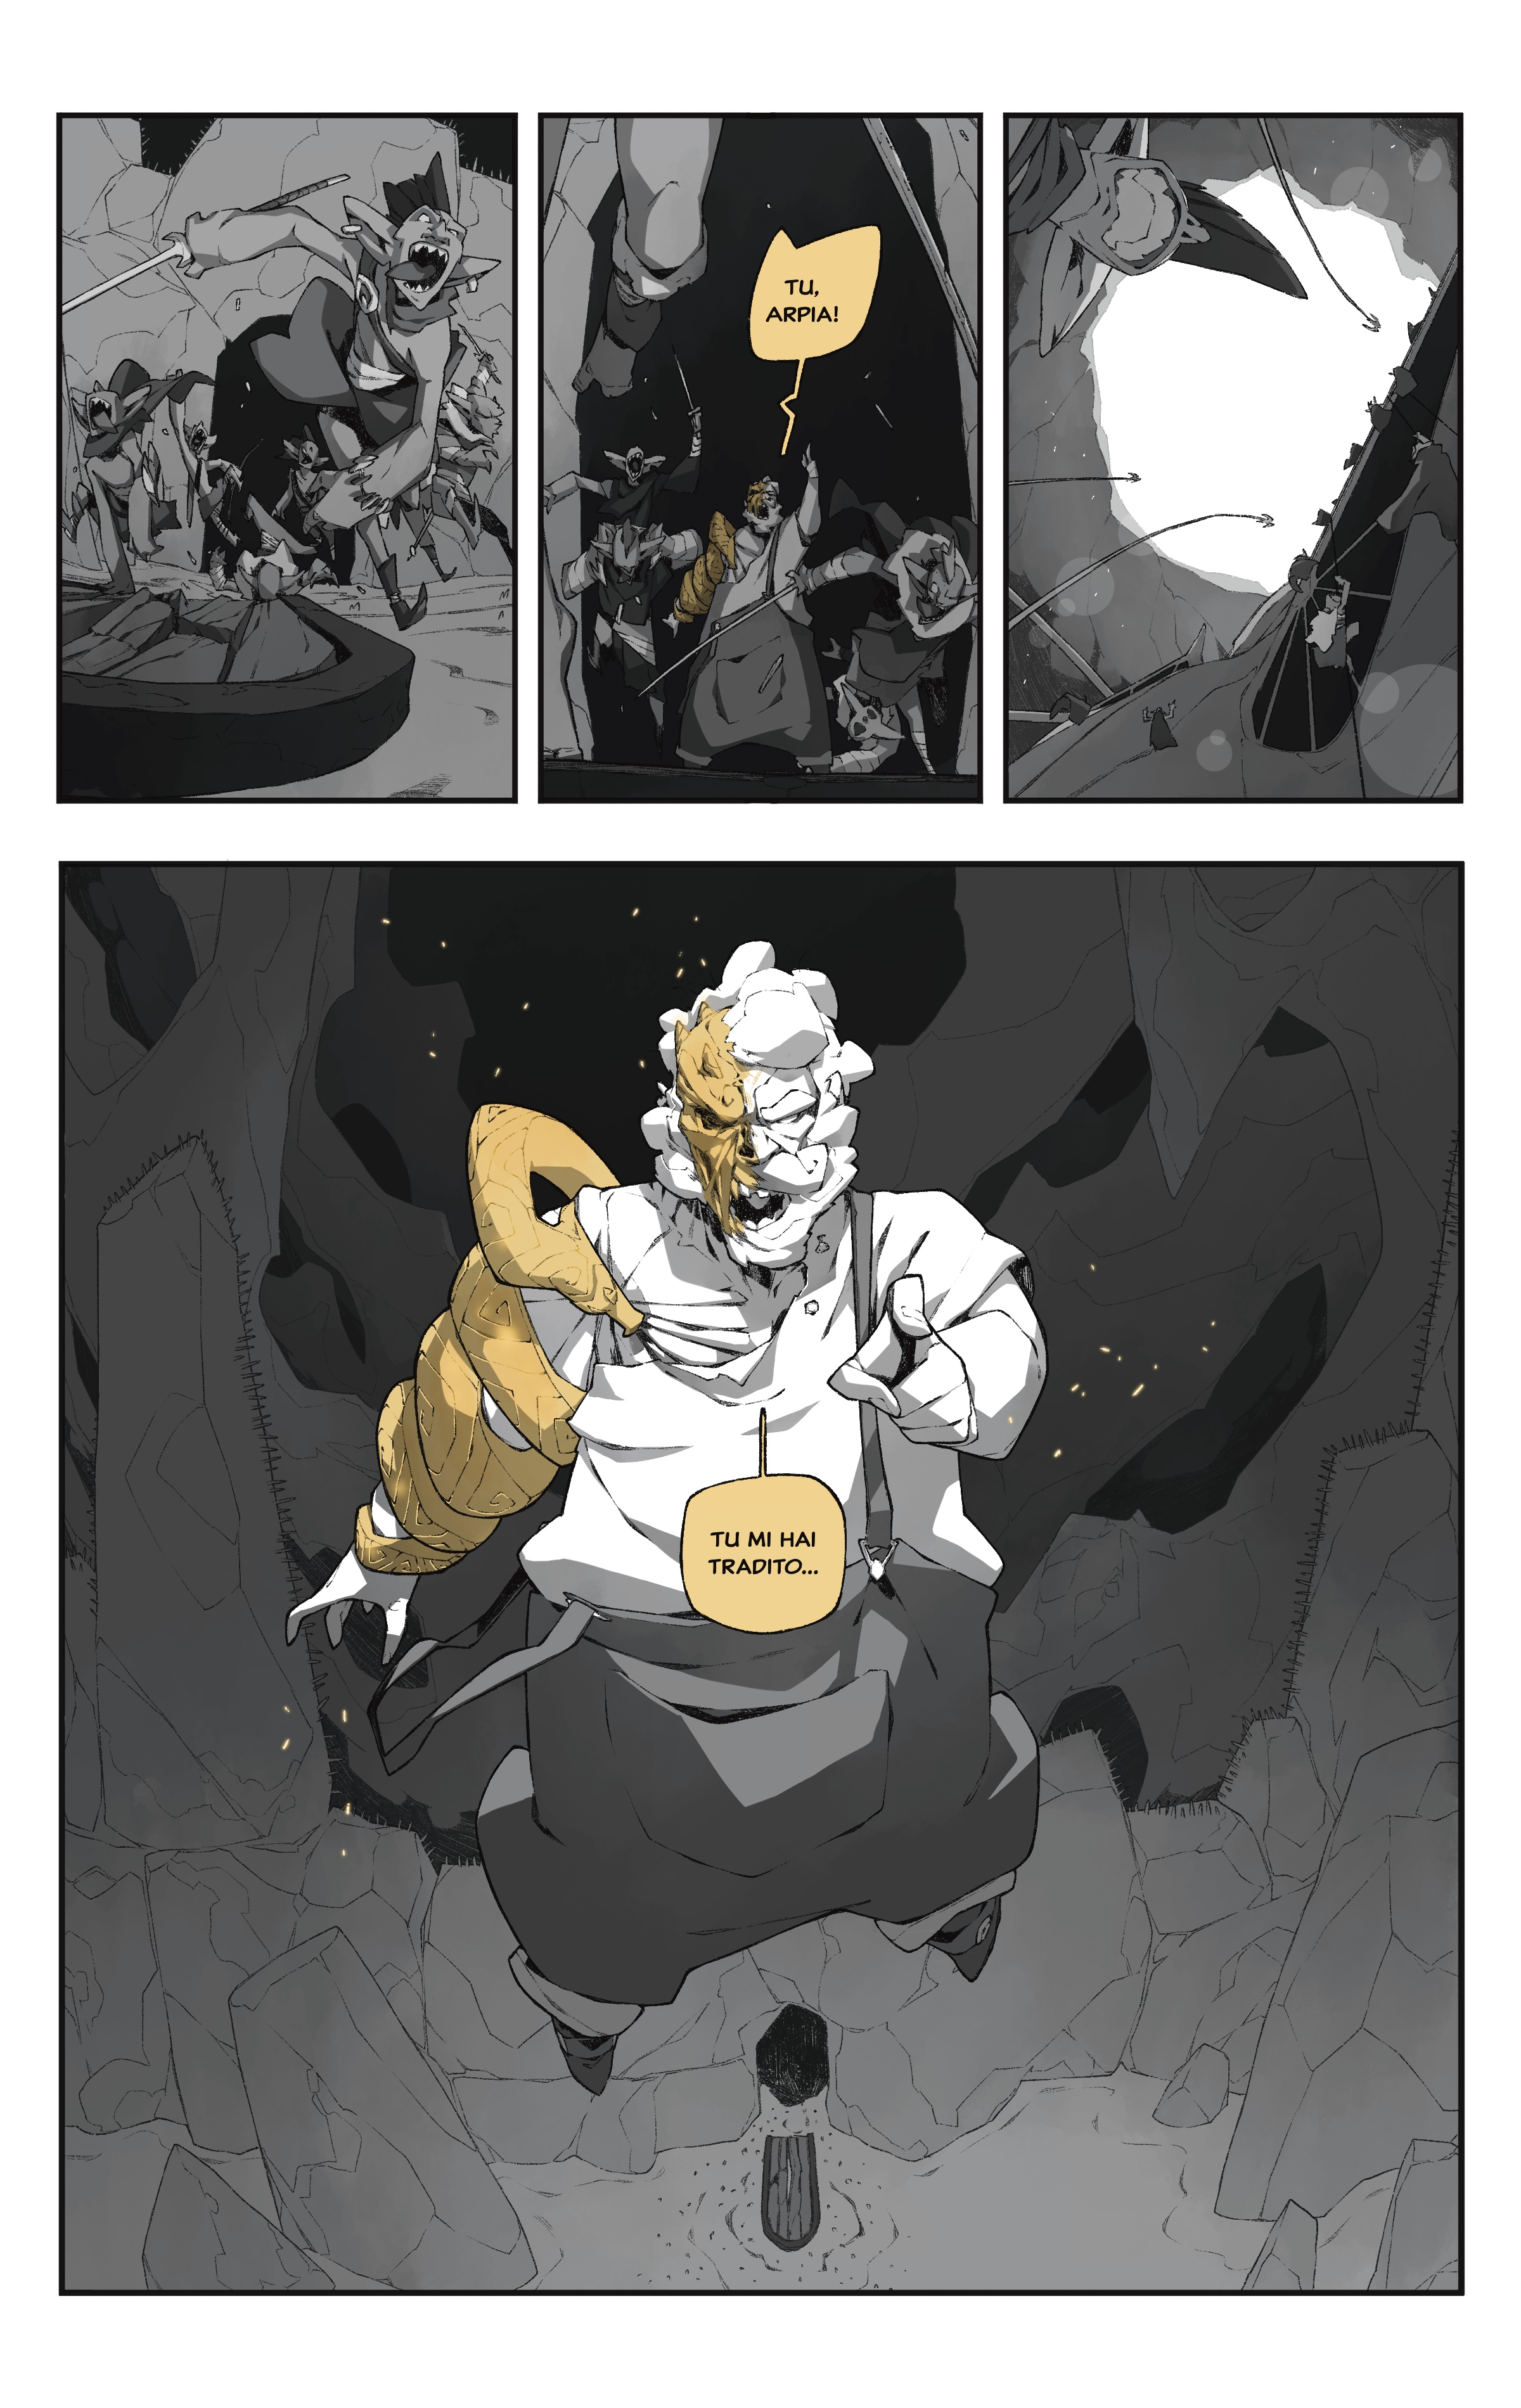

In [1]:
from PIL import Image
import imageio

im = imageio.imread('Tavola5_episodio1_cap13.JPG')
Image.fromarray(im)

In [2]:
!{sys.executable} -m pip install scikit-image

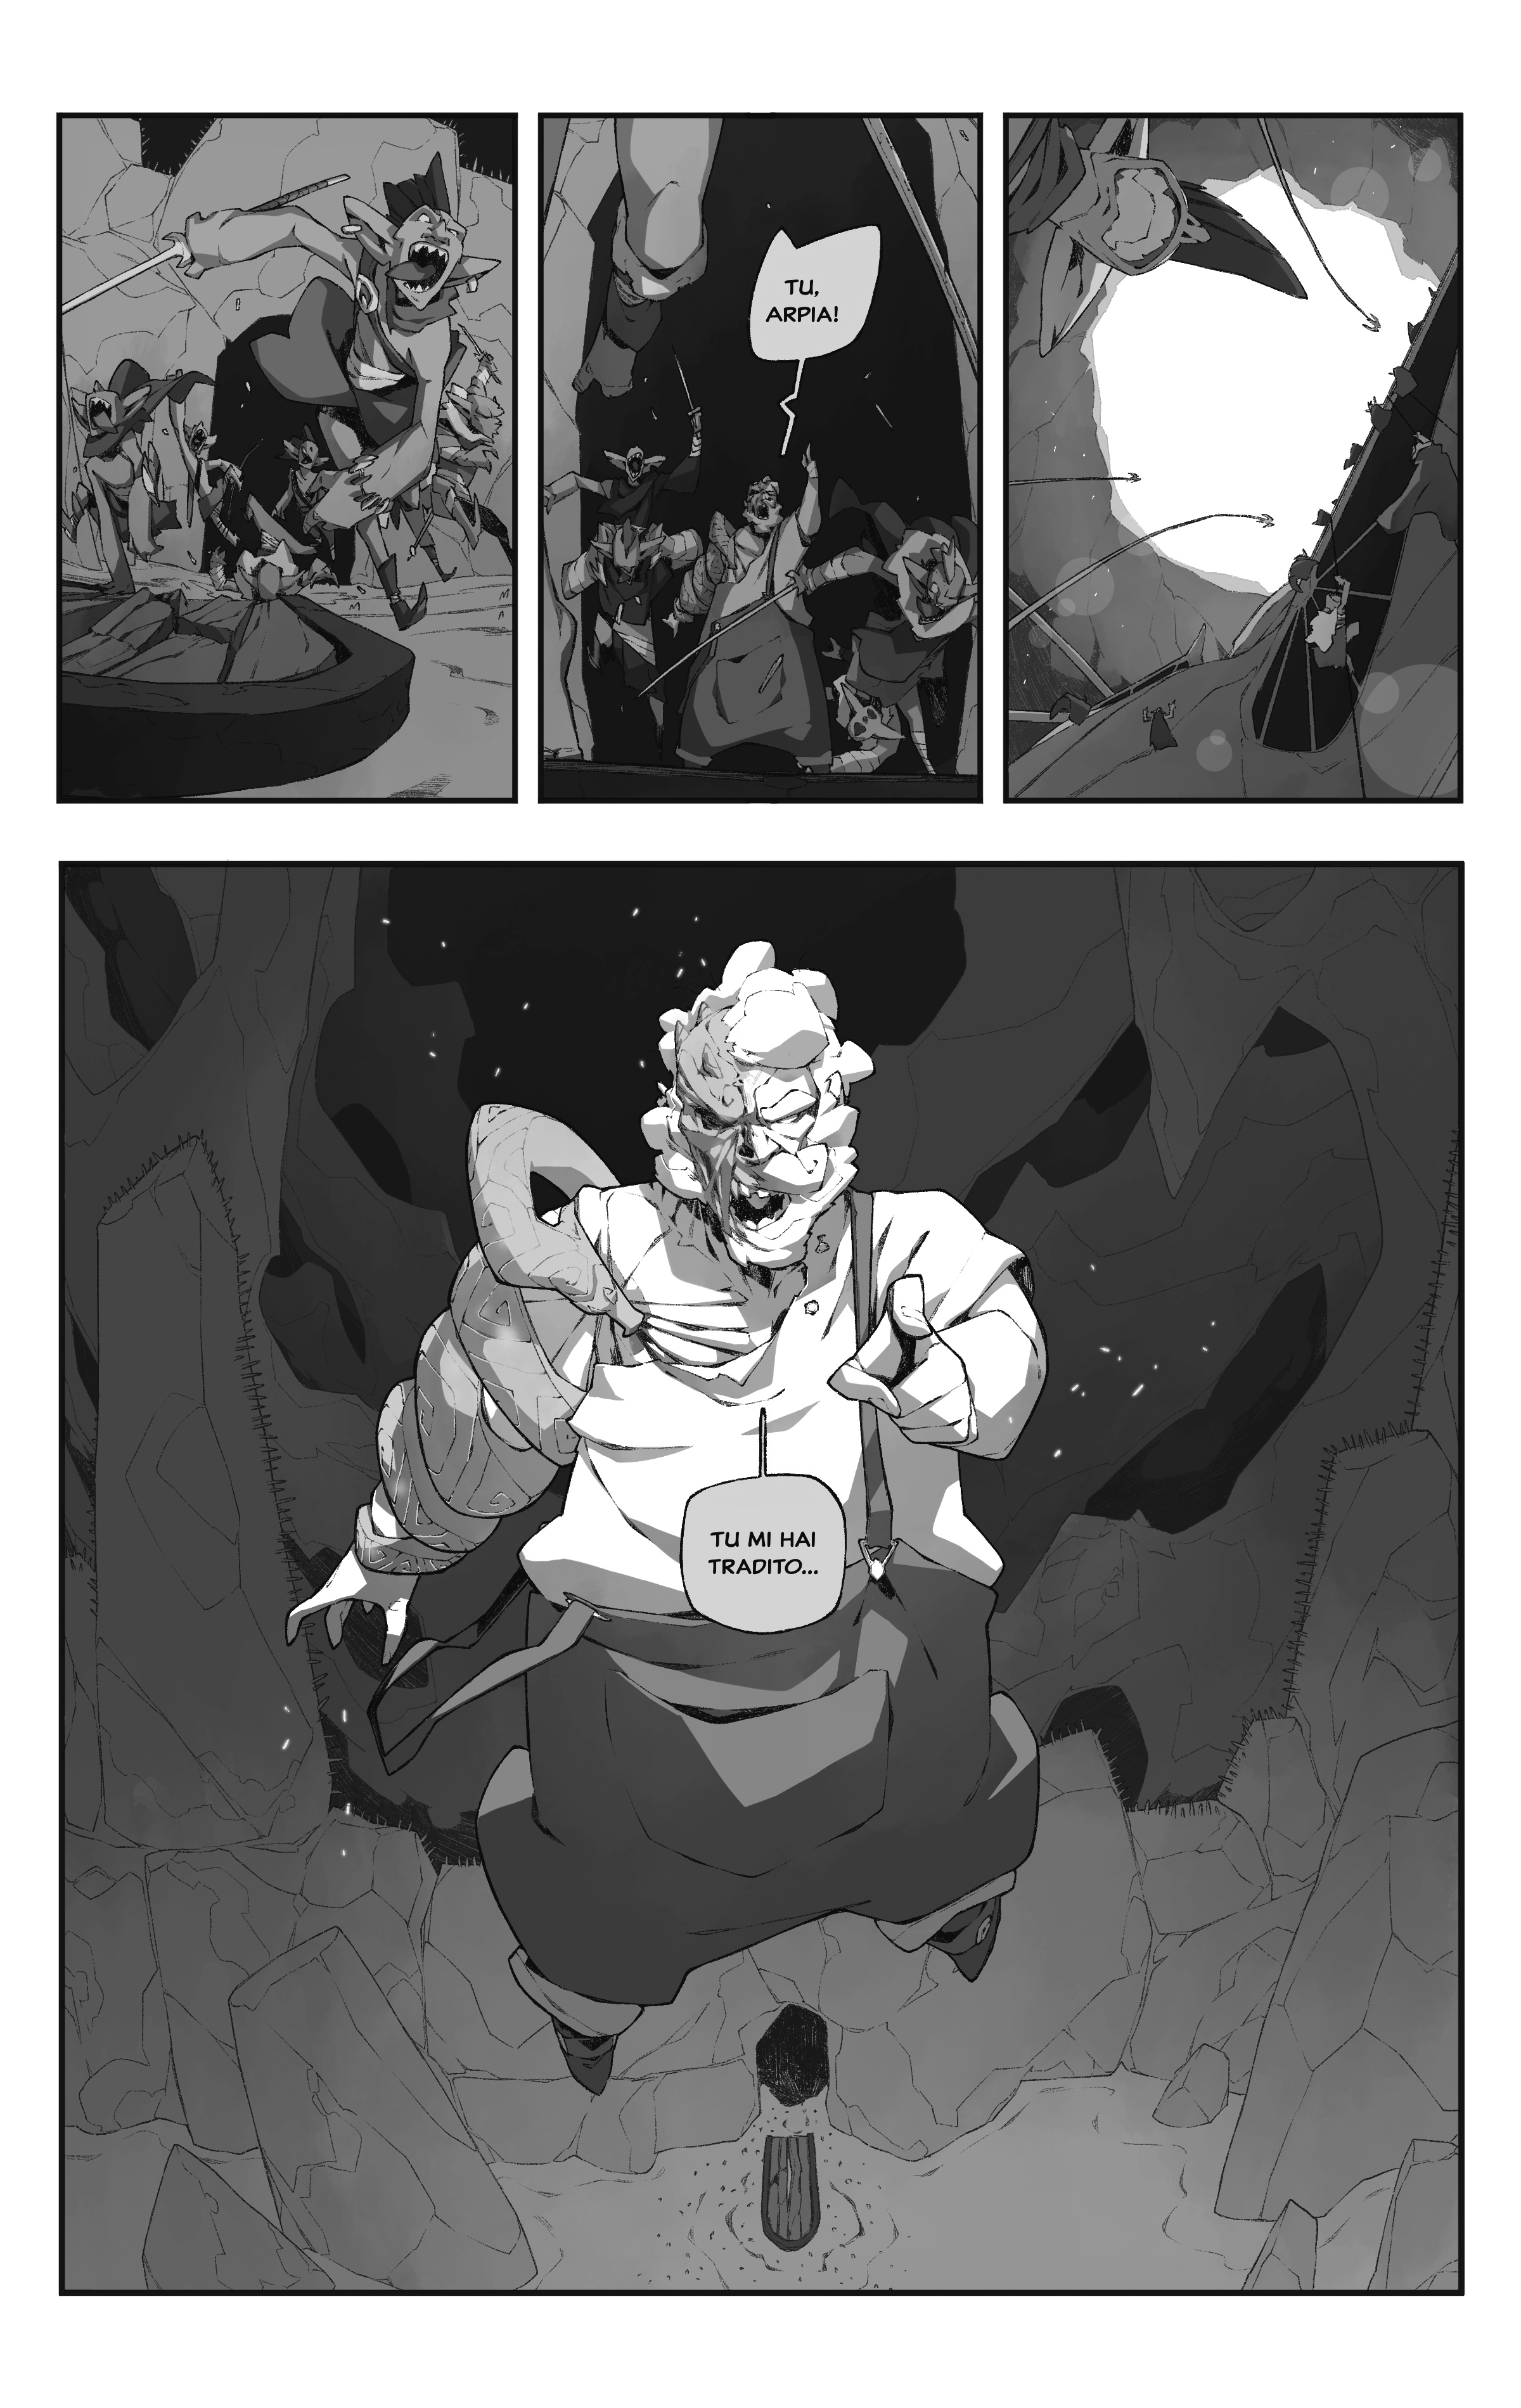

In [3]:
from skimage.color import rgb2gray

grayscale = rgb2gray(im)
Image.fromarray((grayscale * 255).astype('uint8'), 'L')

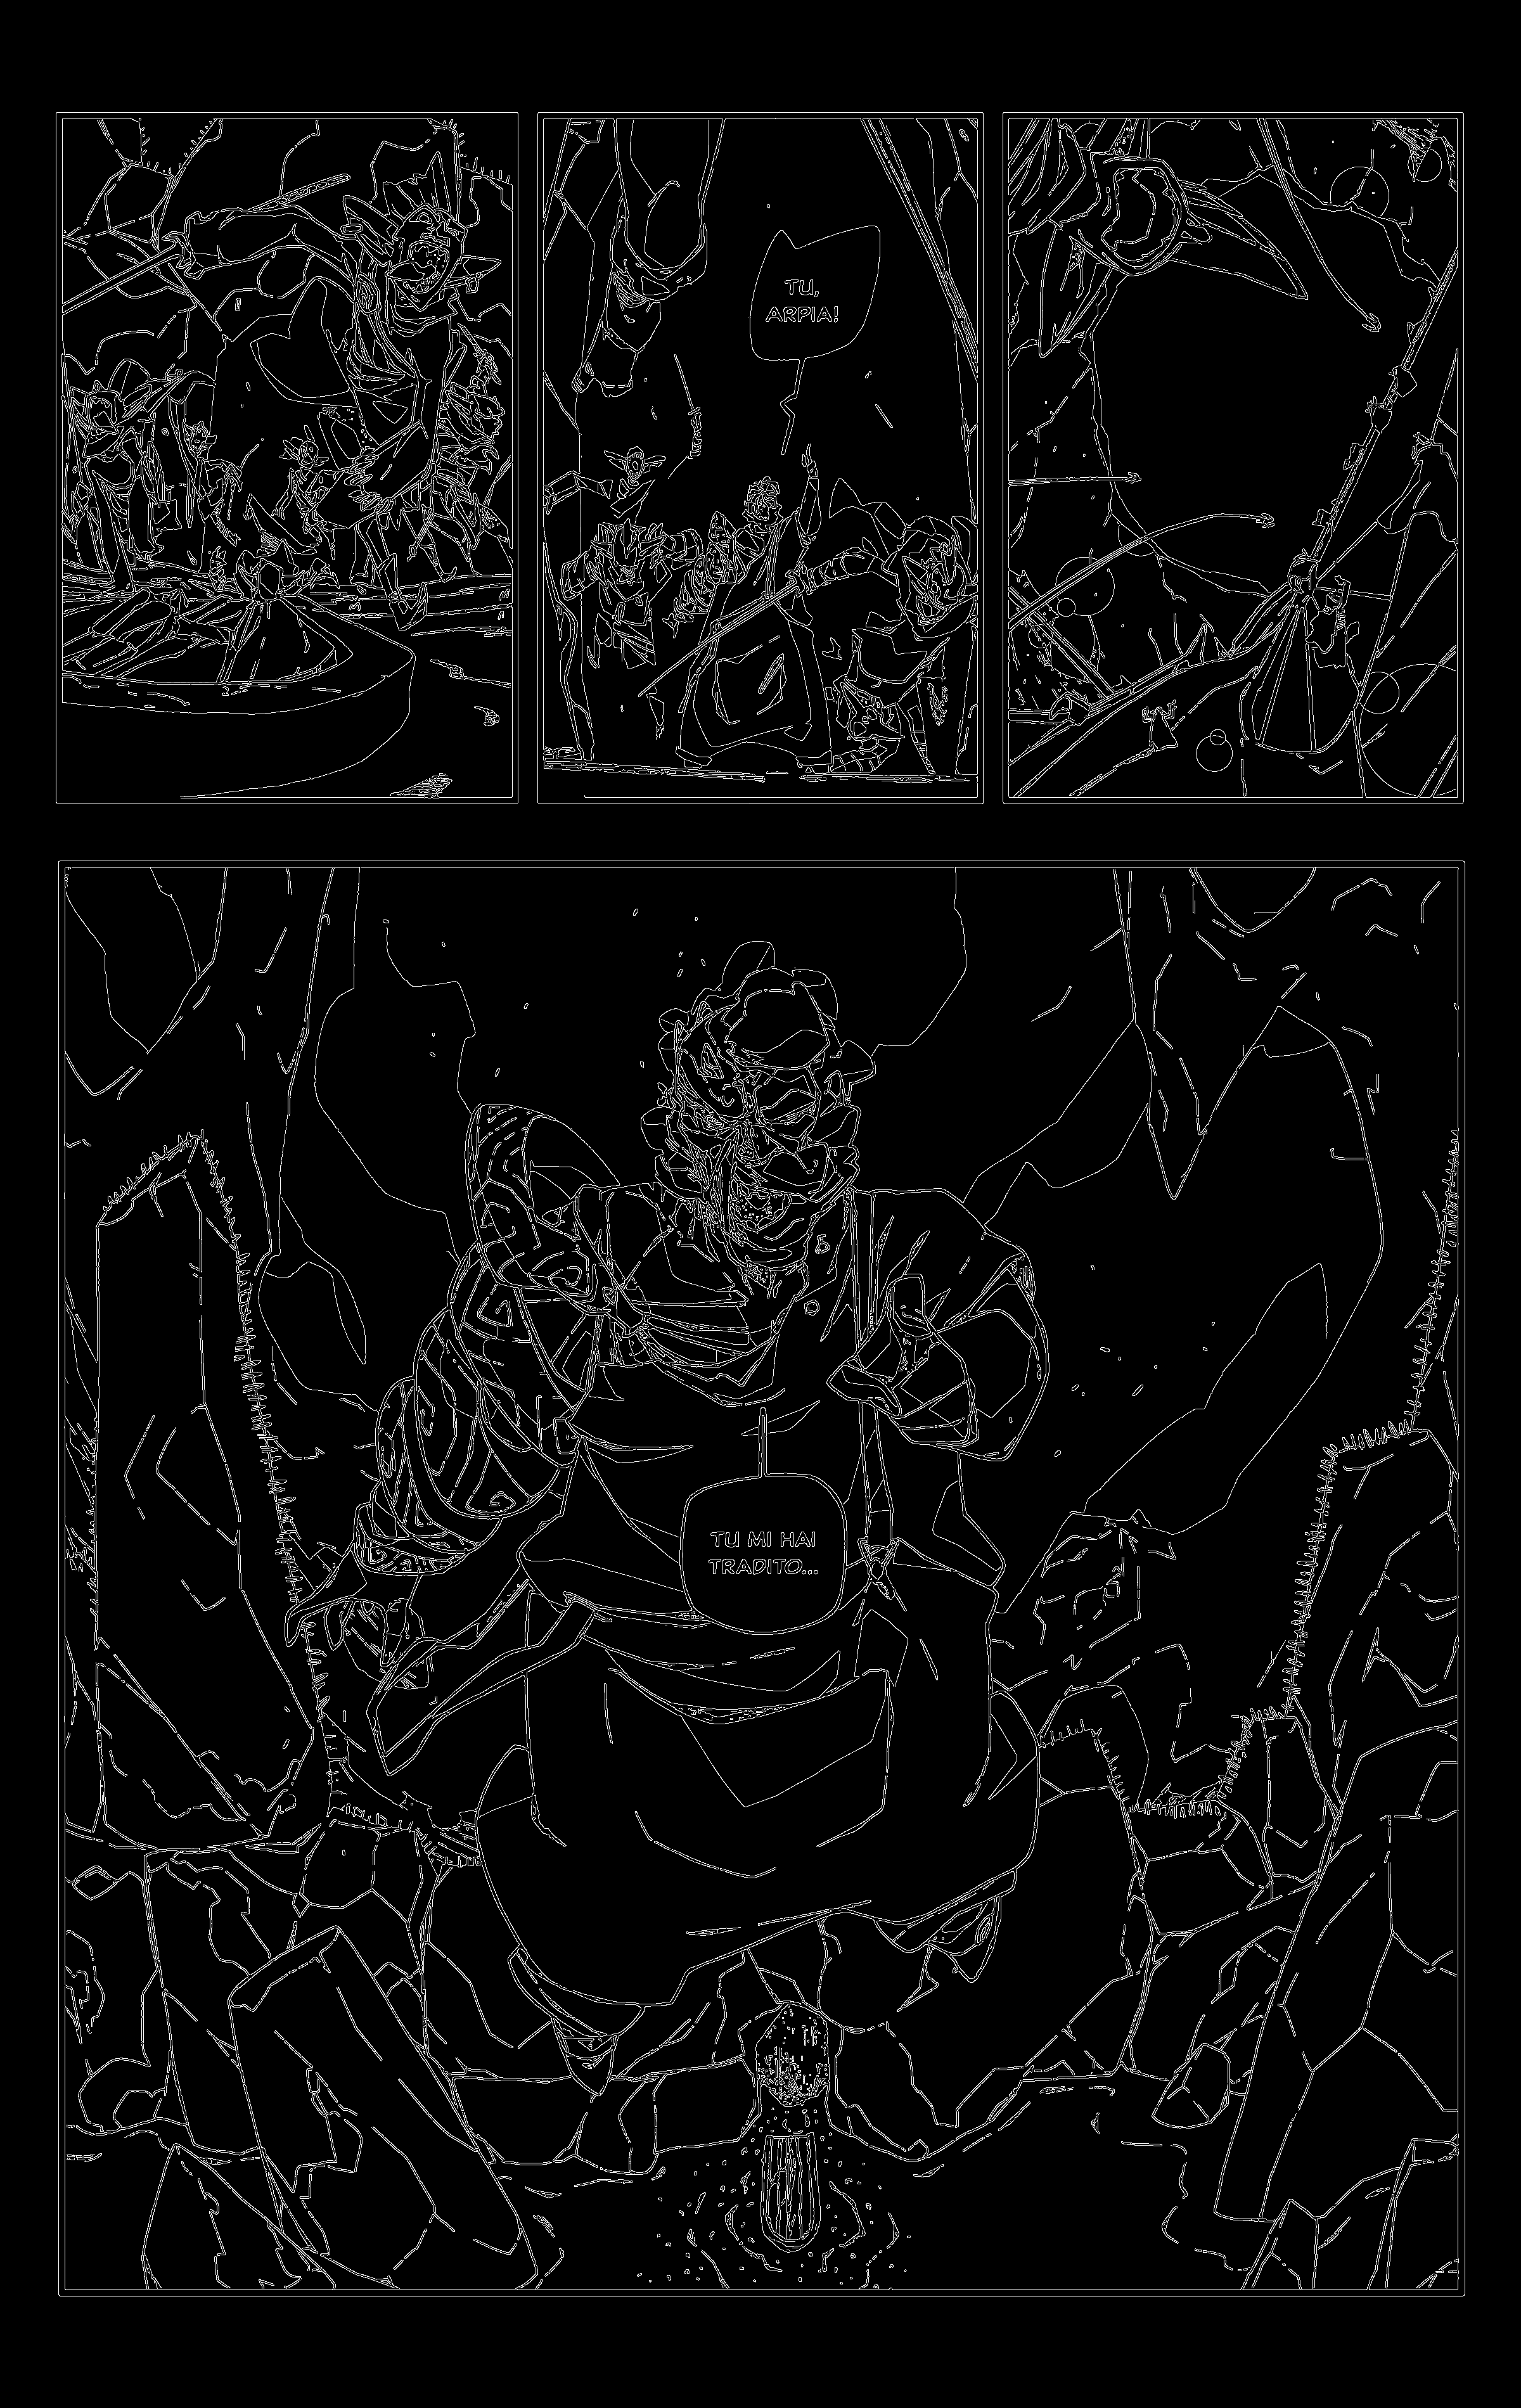

In [4]:
from skimage.feature import canny

edges = canny(grayscale)
Image.fromarray(edges)


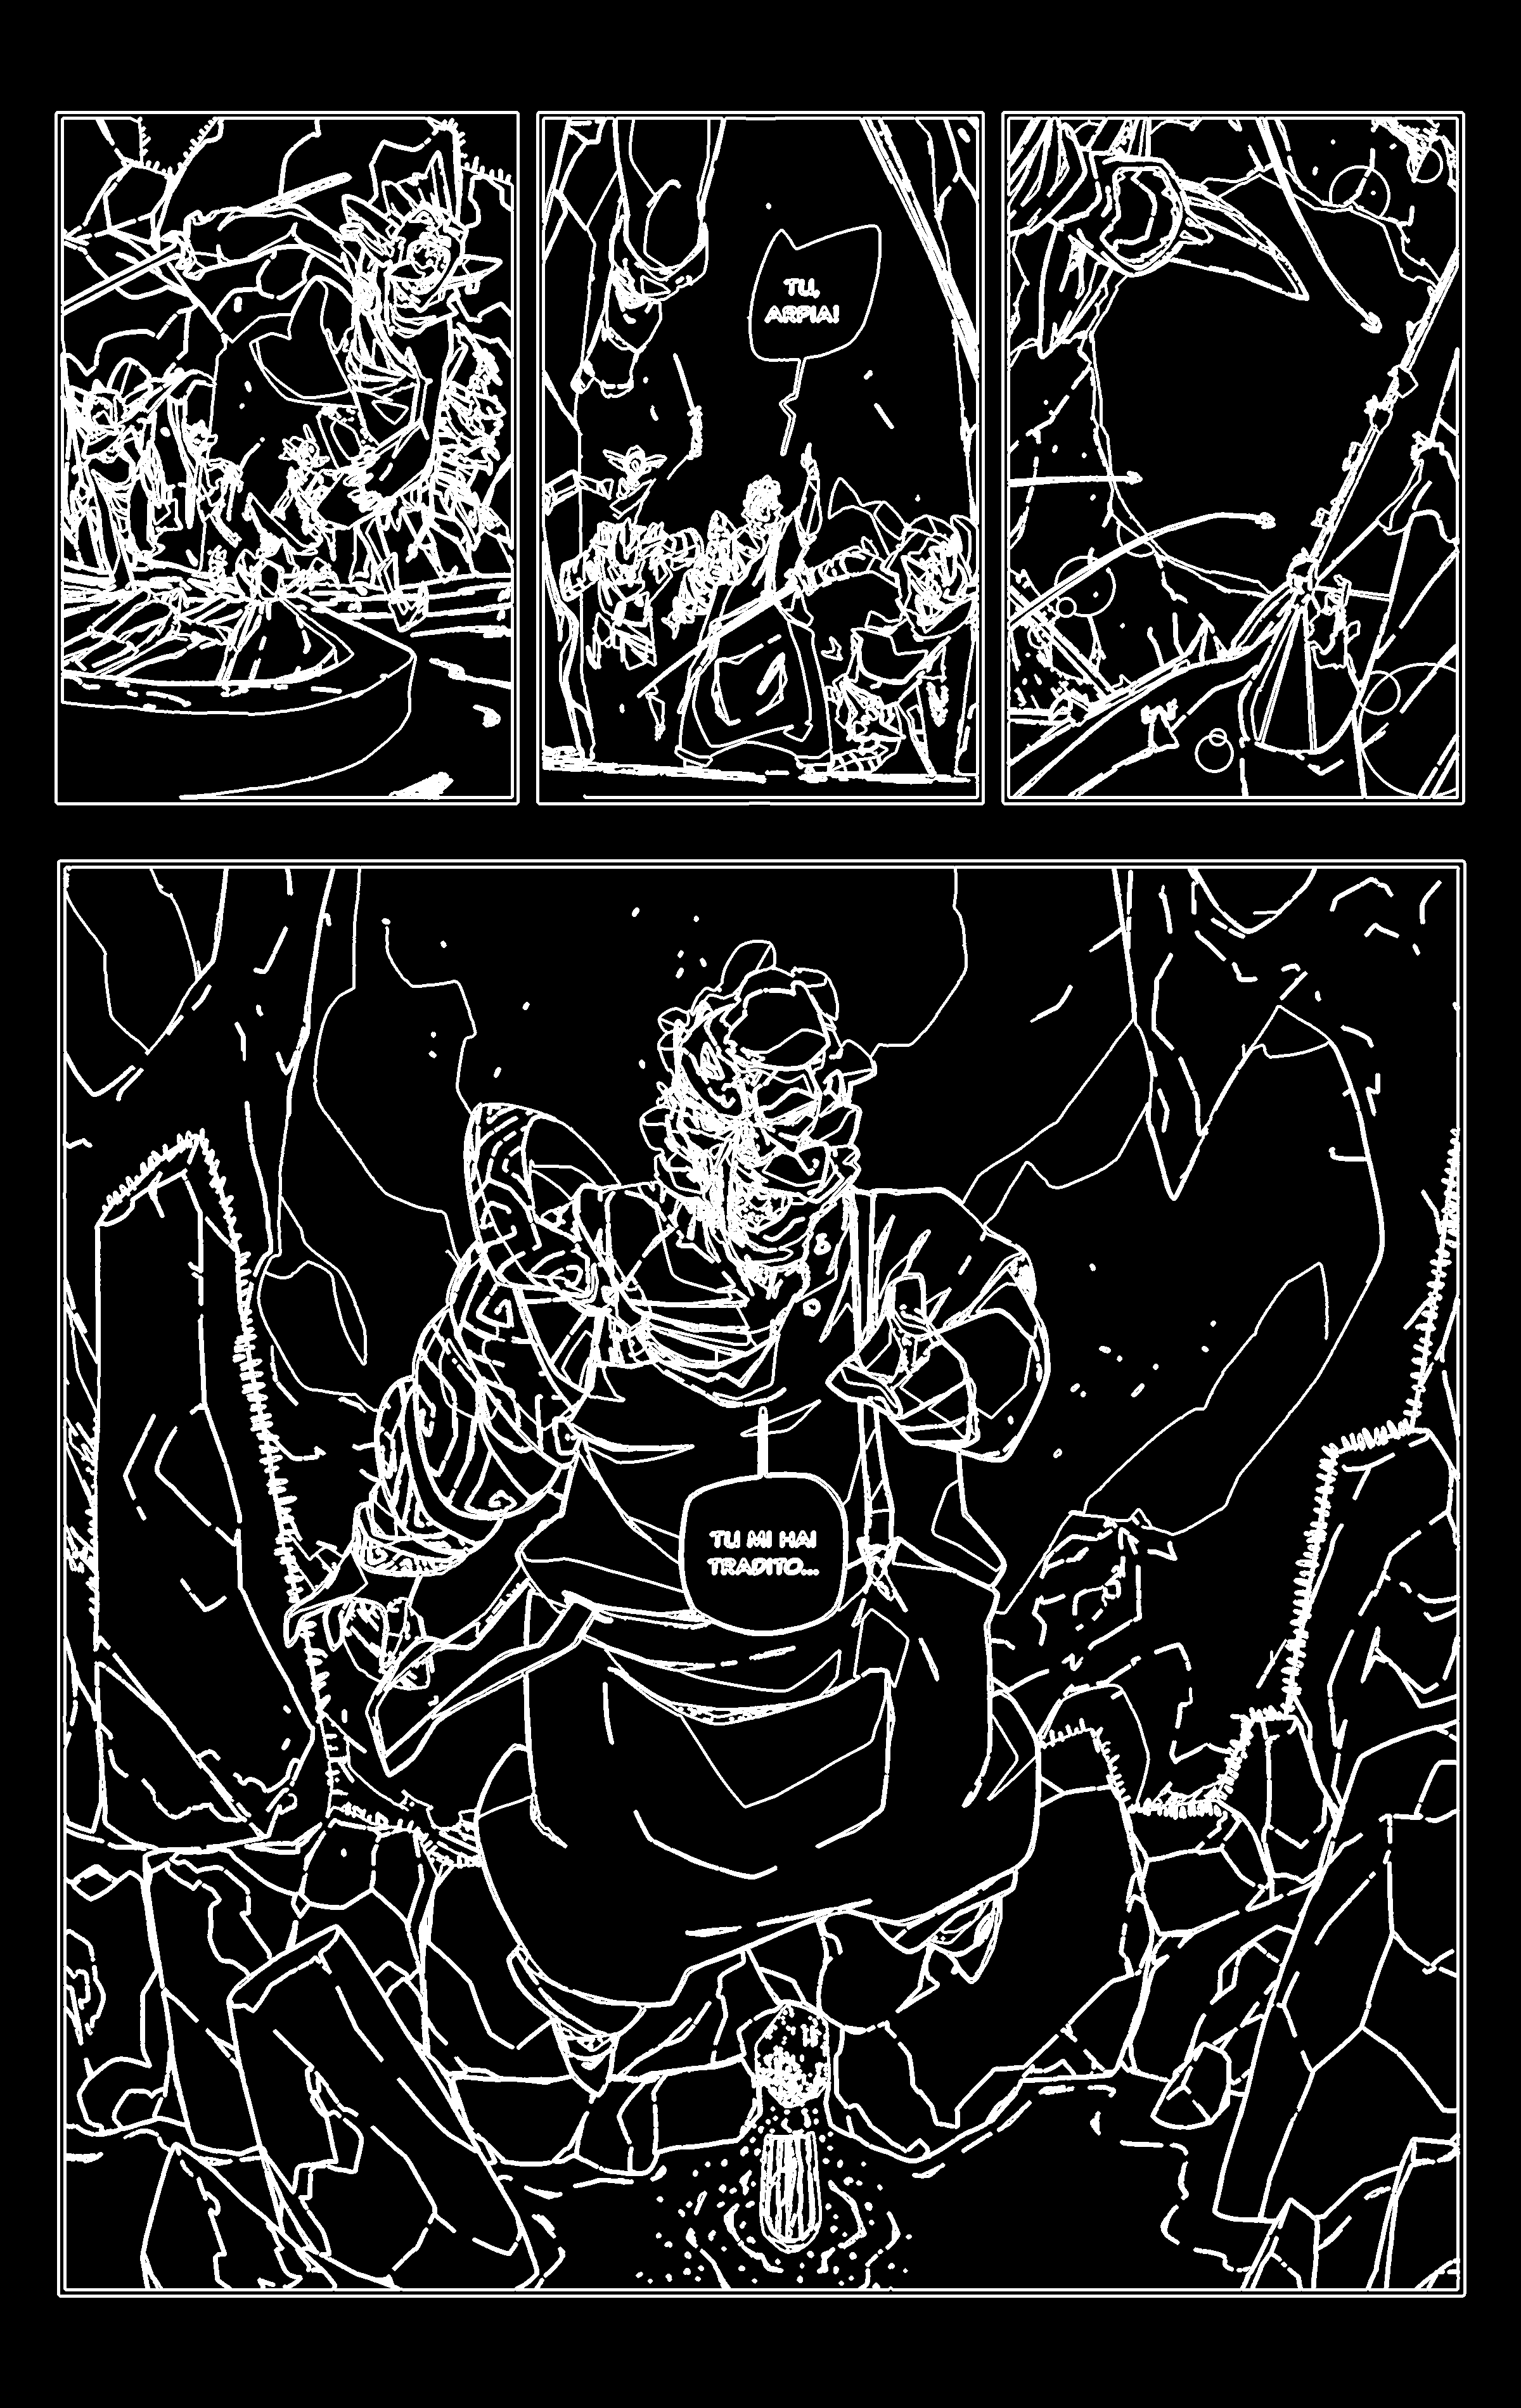

In [5]:
from skimage.morphology import dilation

thick_edges = dilation(dilation(edges))
Image.fromarray(thick_edges)


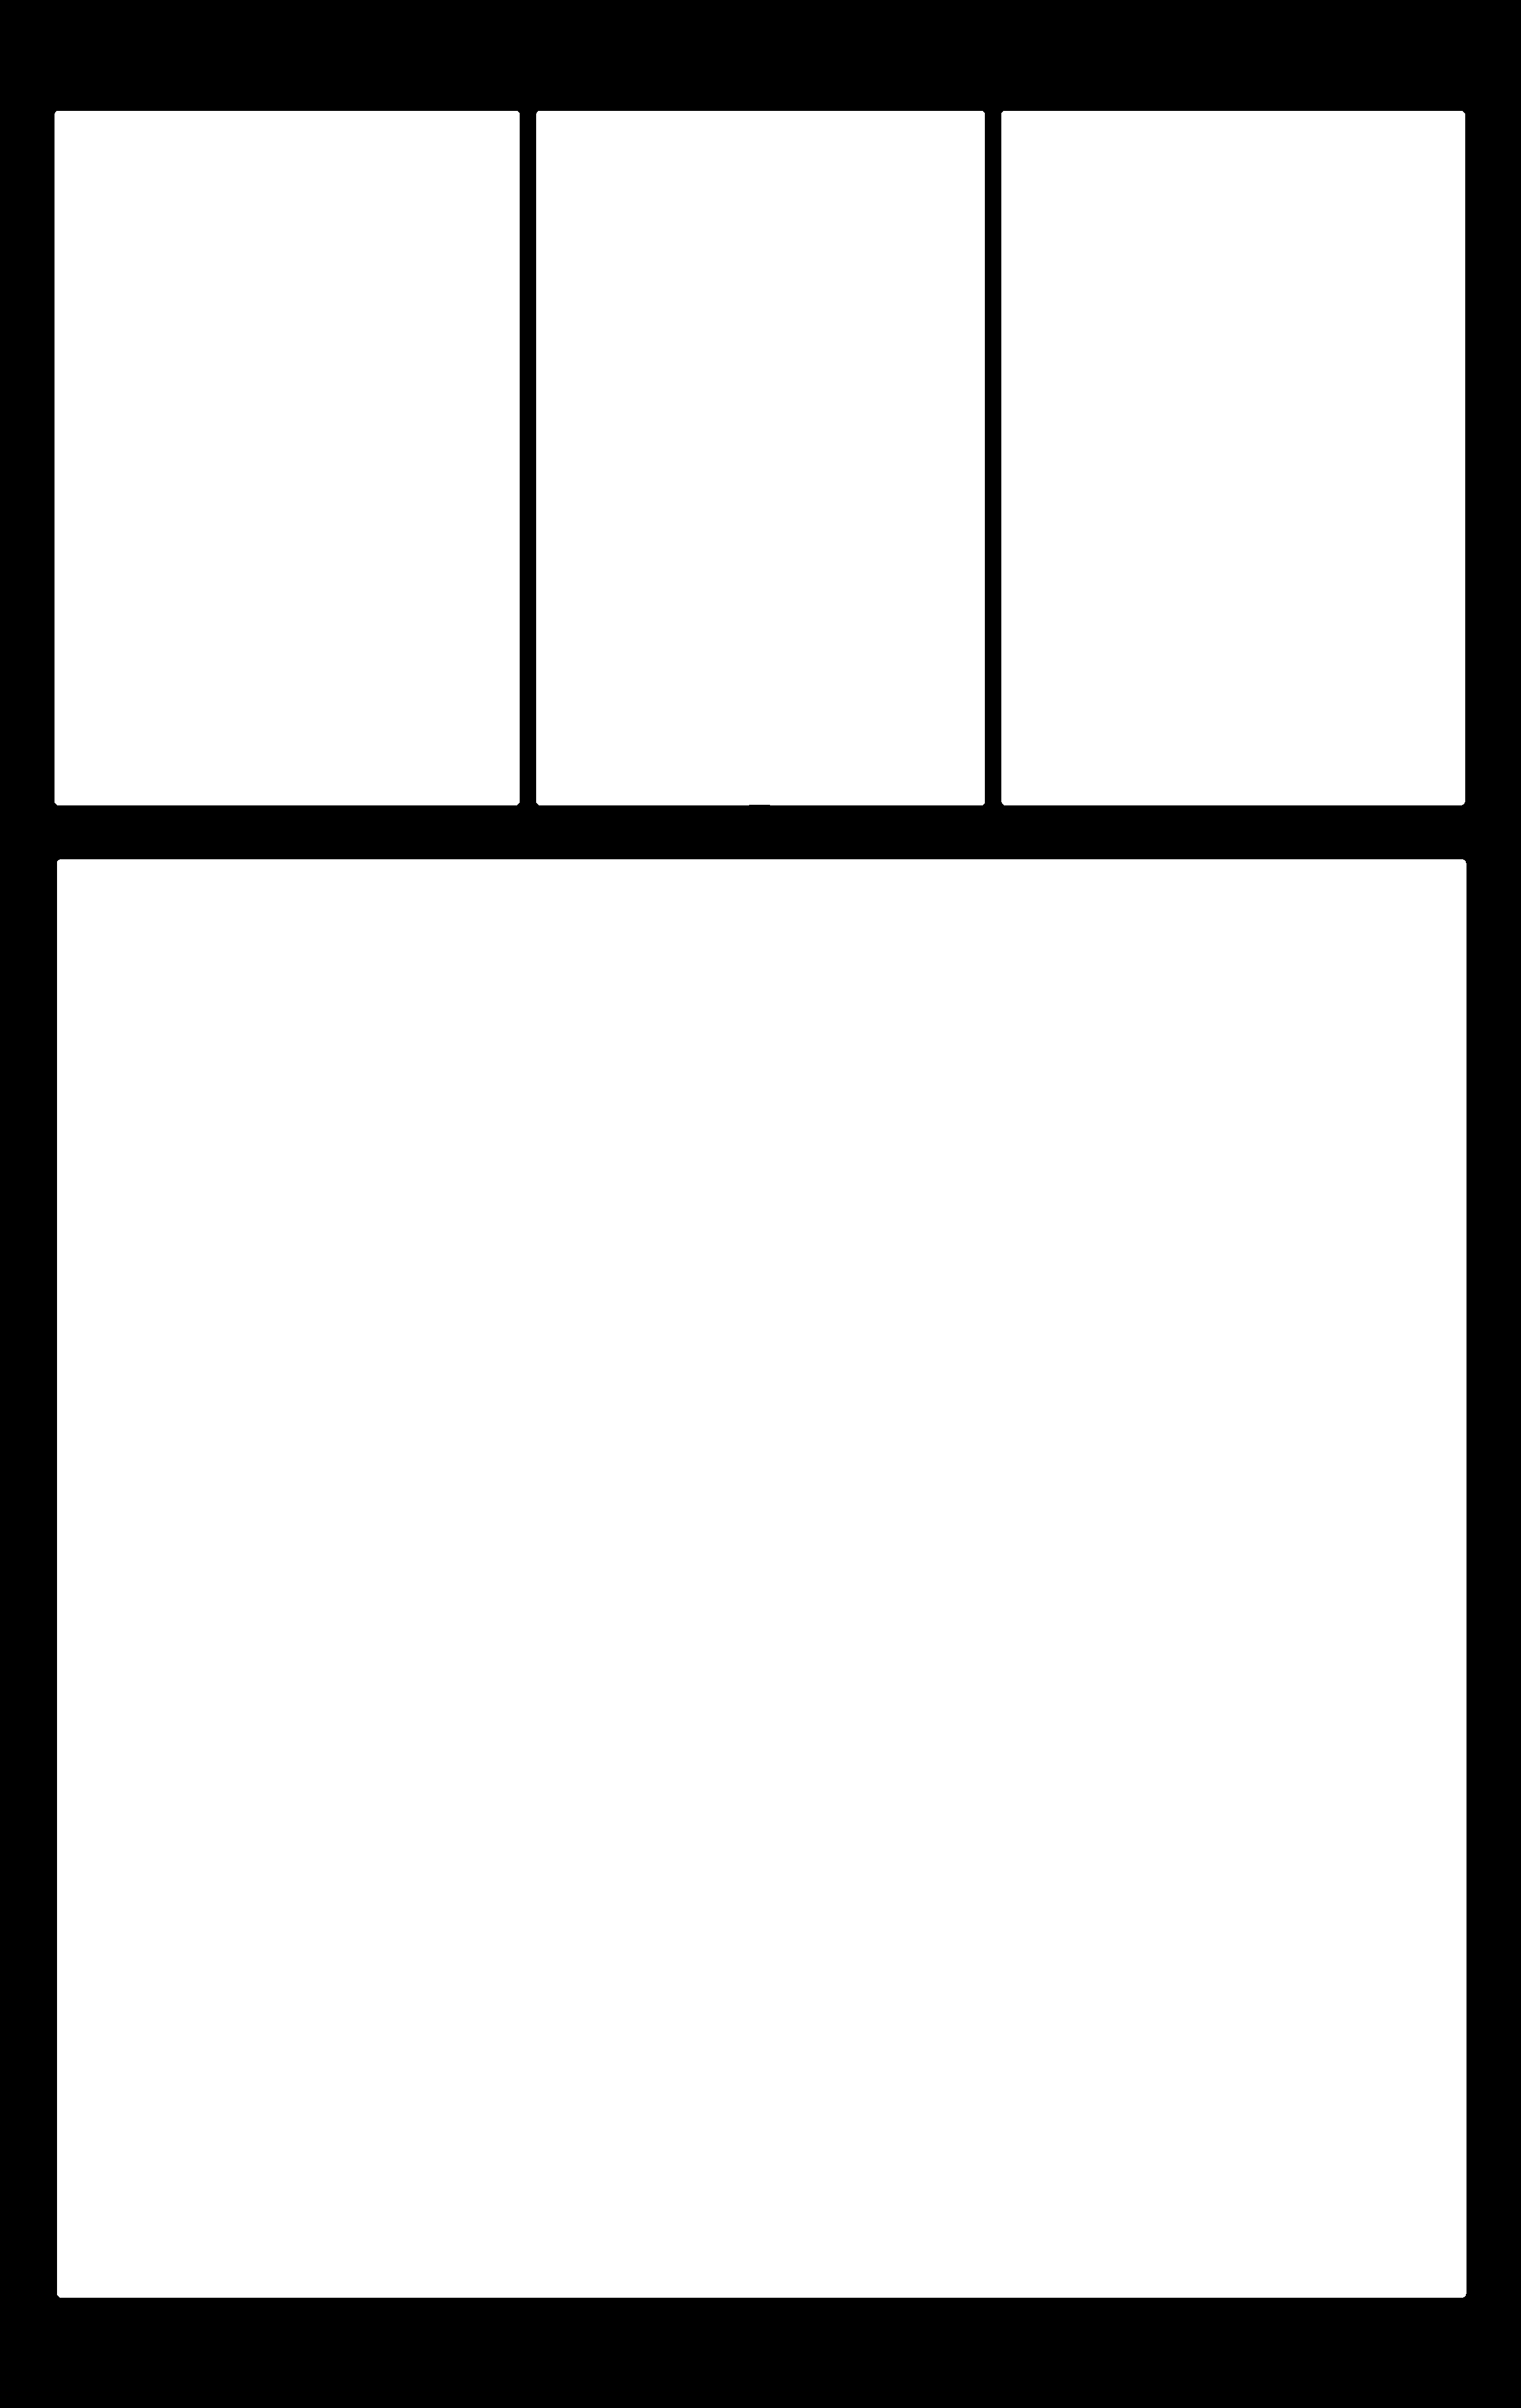

In [6]:
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(thick_edges)
Image.fromarray(segmentation)


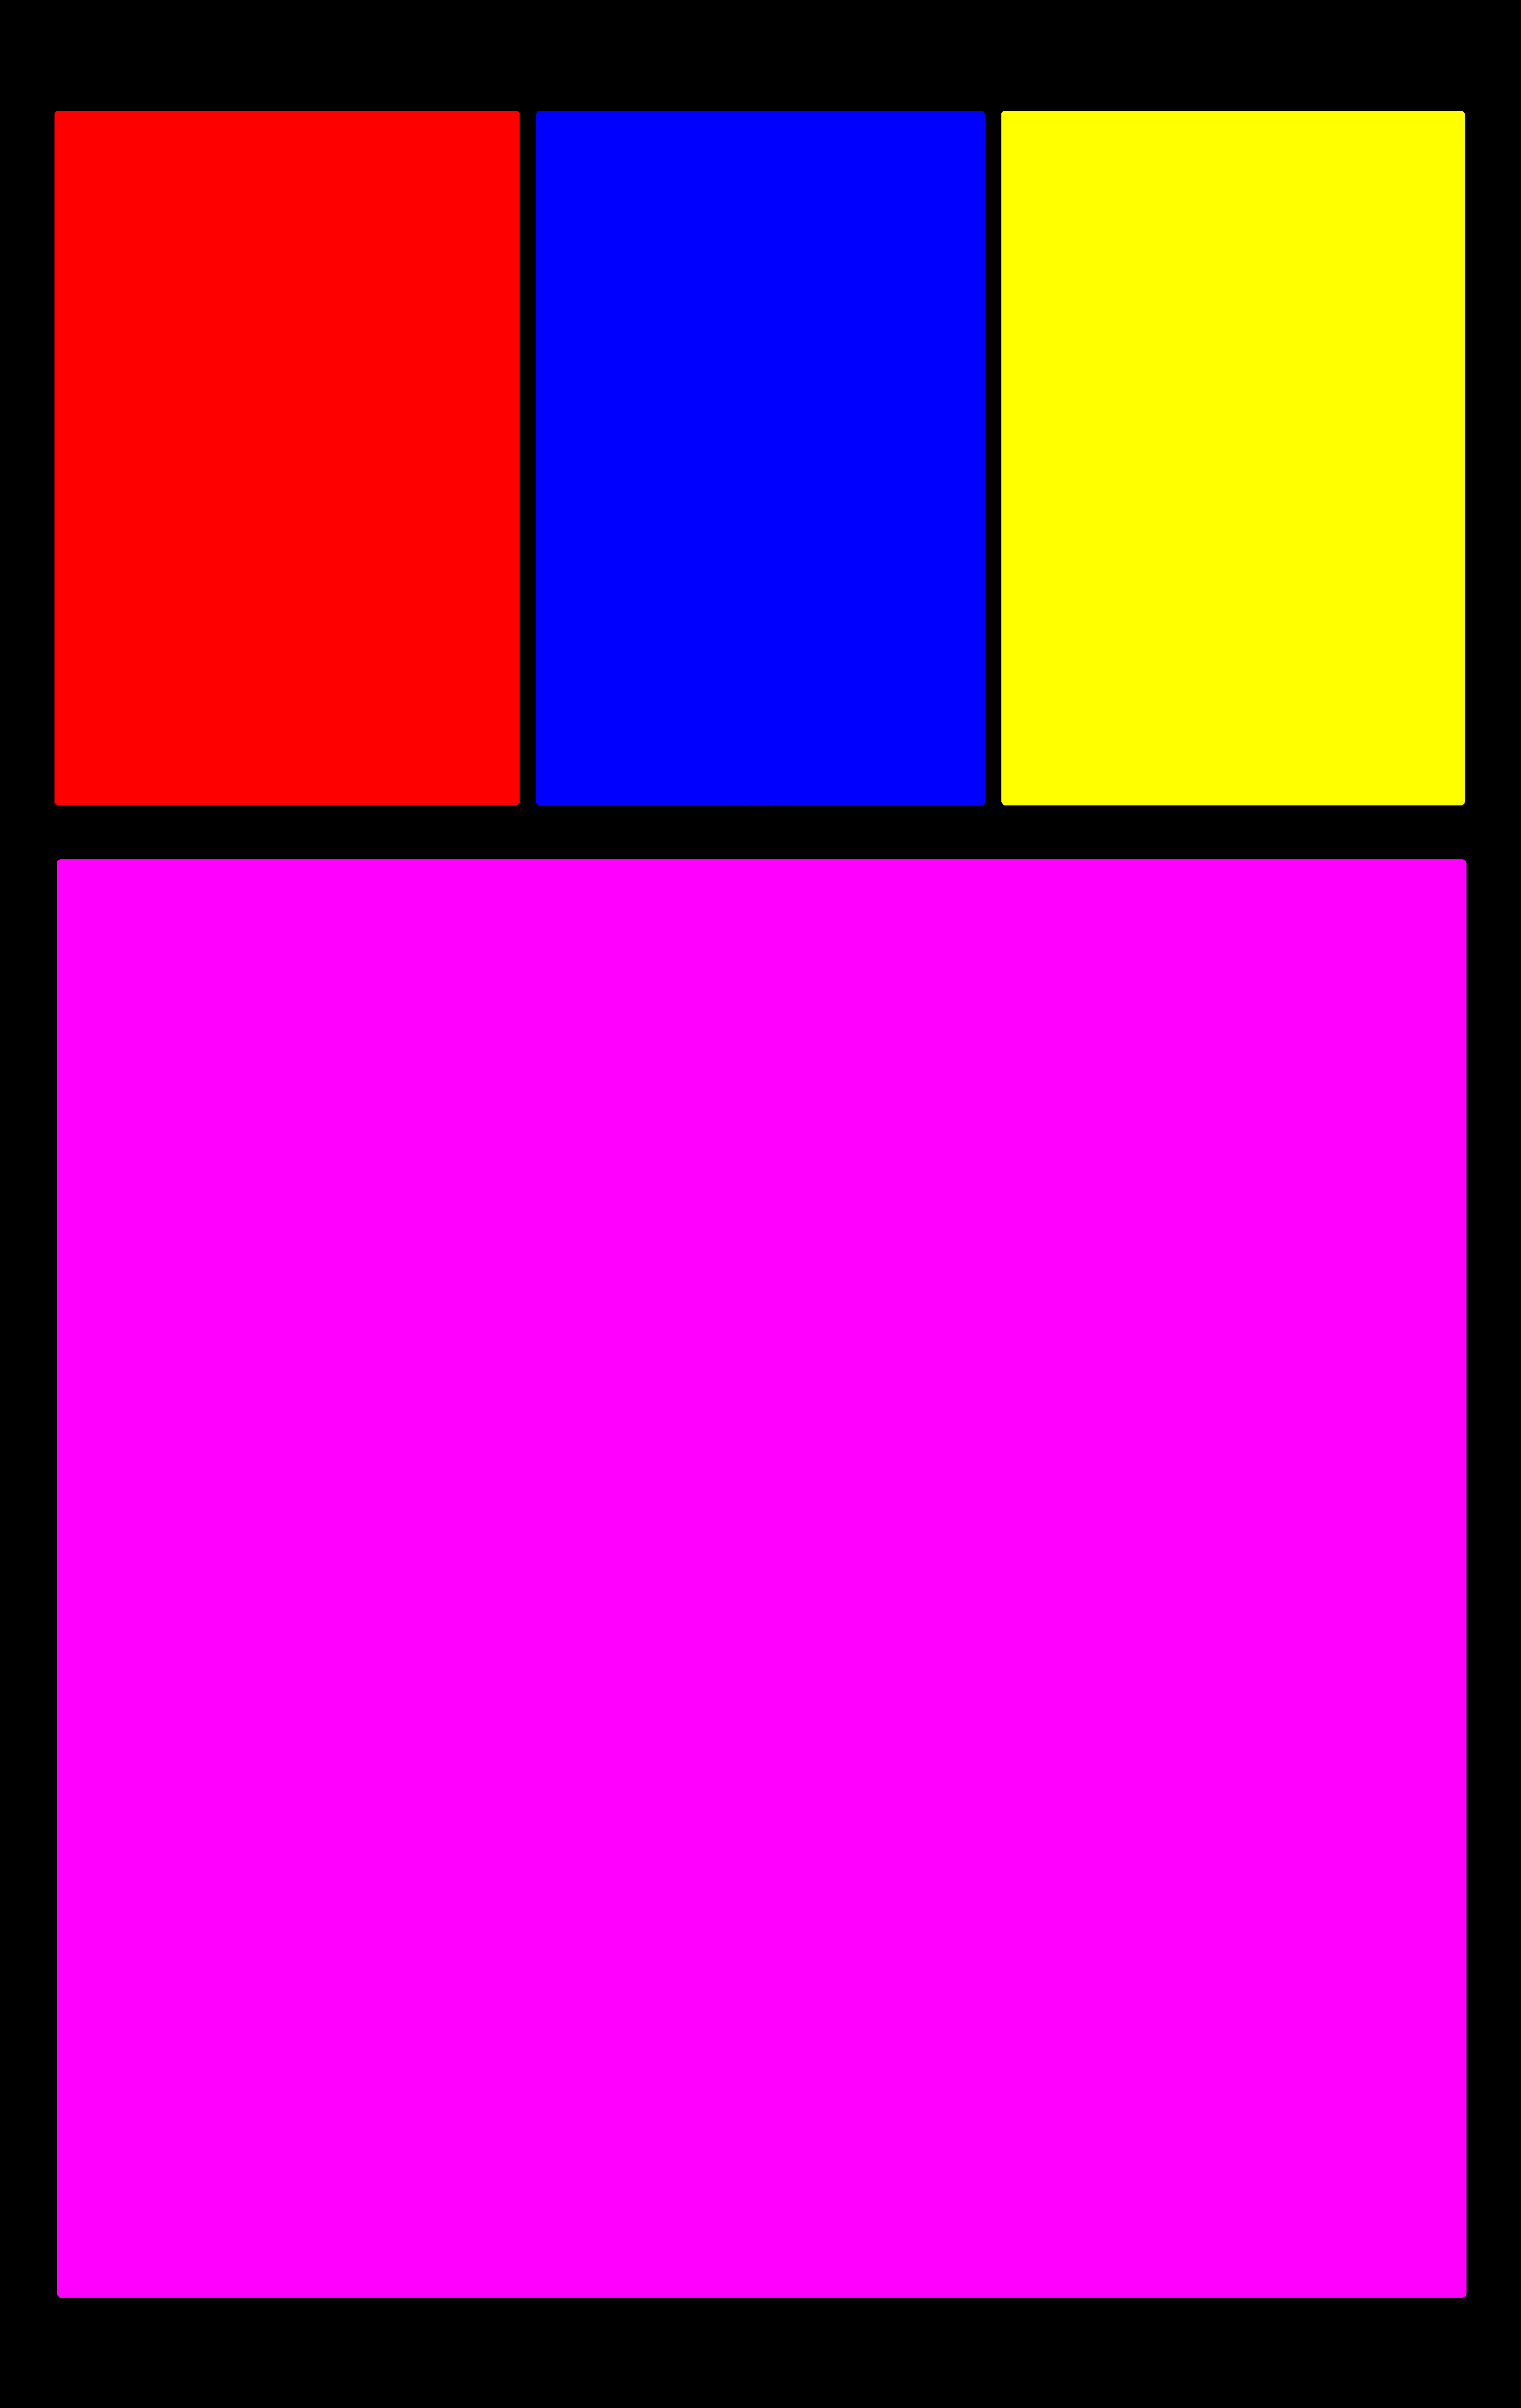

In [7]:
from skimage.measure import label
from skimage.color import label2rgb
import numpy as np

labels = label(segmentation)

Image.fromarray(np.uint8(label2rgb(labels, bg_label=0) * 255))


In [8]:
from skimage.measure import regionprops

def do_bboxes_overlap(a, b):
    return (
        a[0] < b[2] and
        a[2] > b[0] and
        a[1] < b[3] and
        a[3] > b[1]
    )

def merge_bboxes(a, b):
    return (
        min(a[0], b[0]),
        min(a[1], b[1]),
        max(a[2], b[2]),
        max(a[3], b[3])
    )

regions = regionprops(labels)
panels = []

for region in regions:

    for i, panel in enumerate(panels):
        if do_bboxes_overlap(region.bbox, panel):
            panels[i] = merge_bboxes(panel, region.bbox)
            break
    else:
        panels.append(region.bbox)



In [9]:
for i, bbox in reversed(list(enumerate(panels))):
    area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    if area < 0.01 * im.shape[0] * im.shape[1]:
        del panels[i]


For some reason this doesn't work
```python
panel_img = np.zeros_like(labels)

for i, bbox in enumerate(panels, start=1):
    panel_img[bbox[0]:bbox[2], bbox[1]:bbox[3]] = i

Image.fromarray(label2rgb(panel_img, bg_label=0) * 255).astype('uint8')
```

In [10]:
import os
def are_bboxes_aligned(a, b, axis):
    return (
        a[0 + axis] < b[2 + axis] and
        b[0 + axis] < a[2 + axis]
    )

def cluster_bboxes(bboxes, axis=0):

    clusters = []

    # Regroup bboxes which overlap along the current axis.
    # For instance, two panels on the same row overlap
    # along their verticial coordinate.
    for bbox in bboxes:
        for cluster in clusters:
            if any(
                are_bboxes_aligned(b, bbox, axis=axis)
                for b in cluster
            ):
                cluster.append(bbox)
                break
        else:
            clusters.append([bbox])

    # We want rows to be ordered from top to bottom, and
    # columns to be ordered from left to right.
    clusters.sort(key=lambda c: c[0][0 + axis])

    # For each row, we want to cluster the panels of that
    # row into columns, etc. etc.
    for i, cluster in enumerate(clusters):
        if len(cluster) > 1:
            clusters[i] = cluster_bboxes(
                bboxes=cluster,
                axis=1 if axis == 0 else 0
            )

    return clusters

clusters = cluster_bboxes(panels)
def flatten(l):
    for el in l:
        if isinstance(el, list):
            yield from flatten(el)
        else:
            yield el

os.makedirs('panels')

for i, bbox in enumerate(flatten(clusters)):
    panel = im[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    Image.fromarray(panel).save(f'panels/{i}.png')


FileExistsError: [Errno 17] File exists: 'panels'